In [ ]:
# --- Colab & Paths ---
from google.colab import drive
import os, subprocess, shlex, glob, re, random, warnings
warnings.filterwarnings("ignore")

# Mount Drive (idempotent)
if not os.path.ismount('/content/drive'):
    drive.mount('/content/drive', force_remount=False)

# === Your project paths ===
DRIVE_ROOT = "/content/drive/MyDrive/multiclassproject"  # <- keep this
CREMA_DIR_DRIVE = f"{DRIVE_ROOT}/crema"                  # folder that contains AudioWAV/
CREMA_AUDIO_DIR_DRIVE = f"{CREMA_DIR_DRIVE}/AudioWAV"    # wav files live here

# Local fast workspace on VM SSD
LOCAL_ROOT = "/content/data/crema_only_project"
LOCAL_CREMA = f"{LOCAL_ROOT}/CREMA"
CREMA_AUDIO_DIR_LOCAL = f"{LOCAL_CREMA}/AudioWAV"
os.makedirs(CREMA_AUDIO_DIR_LOCAL, exist_ok=True)

# Quick sanity checks
assert os.path.isdir(CREMA_DIR_DRIVE), f"Missing: {CREMA_DIR_DRIVE} (should contain AudioWAV/)"
assert os.path.isdir(CREMA_AUDIO_DIR_DRIVE), f"Missing: {CREMA_AUDIO_DIR_DRIVE} (wav files)"

# Rsync CREMA-D → local (fast)
def _mirror_rsync(src, dst):
    os.makedirs(dst, exist_ok=True)
    !rsync -a --delete --info=progress2 "{src.rstrip('/')}/" "{dst}"

print("Syncing CREMA-D to local /content for speed...")
_mirror_rsync(CREMA_DIR_DRIVE, LOCAL_CREMA)
print("✅ CREMA-D ready at:", CREMA_AUDIO_DIR_LOCAL)

# Count wavs
def _count_wavs(p):
    out = subprocess.check_output(f'find "{p}" -type f -iname "*.wav" | wc -l', shell=True).decode().strip()
    return int(out or 0)

print("WAV count (CREMA-D local):", _count_wavs(CREMA_AUDIO_DIR_LOCAL))


Syncing CREMA-D to local /content for speed...
              0   0%    0.00kB/s    0:00:00 (xfr#0, to-chk=0/7445)   
✅ CREMA-D ready at: /content/data/crema_only_project/CREMA/AudioWAV
WAV count (CREMA-D local): 7442


EDA: Raw inspection & label normalization


CREMA-D file count: 7442
label
angry      1271
disgust    1271
fear       1271
happy      1271
neutral    1087
sad        1271
Name: count, dtype: int64


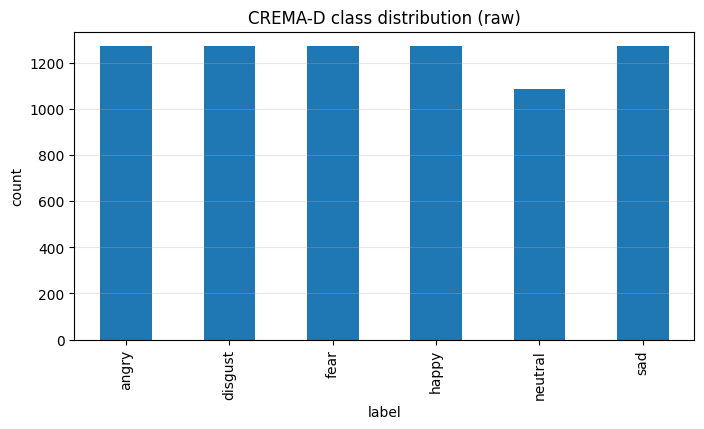

In [ ]:
import pandas as pd
import librosa, numpy as np
from IPython.display import Audio
import matplotlib.pyplot as plt
import seaborn as sns

CREMA_EMOTION_CODEBOOK = {
    'ANG': 'angry', 'DIS': 'disgust', 'FEA': 'fear',
    'HAP': 'happy', 'NEU': 'neutral', 'SAD': 'sad'
}

def crema_raw_labels(crema_audio_dir):
    rows = []
    for d, _, files in os.walk(crema_audio_dir):
        for fn in files:
            if not fn.lower().endswith(".wav"):
                continue
            parts = fn.split('_')  # e.g., 1001_DFA_ANG_XX.wav
            code = parts[2] if len(parts) > 2 else None
            label = CREMA_EMOTION_CODEBOOK.get(code)
            rows.append({"dataset": "CREMA-D", "path": os.path.join(d, fn), "raw_code": code, "label": label})
    return pd.DataFrame(rows)

raw_df = crema_raw_labels(CREMA_AUDIO_DIR_LOCAL)
print("CREMA-D file count:", len(raw_df))
print(raw_df["label"].value_counts(dropna=False).sort_index())

# Simple distribution plot
plt.figure(figsize=(8,4))
raw_df["label"].value_counts().sort_index().plot(kind="bar")
plt.title("CREMA-D class distribution (raw)")
plt.ylabel("count")
plt.grid(axis="y", alpha=0.3)
plt.show()


Diagnostics, thresholds & one-file report

In [ ]:
# Thresholds/targets for diagnostics
TARGET_SR = 22050
TRIM_DB   = 20
PEAK_MIN_FOR_OK = 0.90
ABS_MEAN_MAX_OK = 0.01
SILENCE_MS_OK   = 100
CLIP_PCT_OK     = 0.1
DUR_RANGE_OK    = (1.0, 4.0)  # seconds typical

def audio_stats(y, sr, trim_db=TRIM_DB):
    y_m = librosa.to_mono(y) if y.ndim==2 else y
    dur = len(y_m)/sr if sr else 0.0
    peak = float(np.max(np.abs(y_m))) if y_m.size else 0.0
    rms  = float(np.sqrt(np.mean(y_m**2))) if y_m.size else 0.0
    rms_db = 20*np.log10(rms + 1e-12)
    _, idx = librosa.effects.trim(y_m, top_db=trim_db)
    lead_ms  = (idx[0] / sr) * 1000
    trail_ms = ((len(y_m) - idx[1]) / sr) * 1000
    clip_pct = 100.0 * float(np.mean(np.abs(y_m) >= 0.999)) if y_m.size else 0.0
    return dict(sr=sr, duration_sec=round(dur,3), peak_amp=round(peak,4),
                rms_db=round(rms_db,2), mean_amp=round(float(np.mean(y_m)),4),
                leading_silence_ms=int(lead_ms), trailing_silence_ms=int(trail_ms),
                clipping_pct=round(clip_pct,3))

def inspect_raw(path):
    y, sr = librosa.load(path, sr=None, mono=False)
    return audio_stats(y, sr)

# Demo on a random file
example_path = raw_df["path"].sample(1, random_state=42).iloc[0]
stats = inspect_raw(example_path)
example_path, stats


('/content/data/crema_only_project/CREMA/AudioWAV/1070_MTI_DIS_XX.wav',
 {'sr': 16000,
  'duration_sec': 3.437,
  'peak_amp': 0.2523,
  'rms_db': np.float64(-30.15),
  'mean_amp': -0.0,
  'leading_silence_ms': 480,
  'trailing_silence_ms': 812,
  'clipping_pct': 0.0})

Build manifest + diagnostics flags Visualization

In [ ]:
from tqdm.auto import tqdm

def needs_flags(s):
    dur_lo, dur_hi = DUR_RANGE_OK
    return {
        "needs_resample": (s["sr"] != TARGET_SR),
        "needs_normalize": (s["peak_amp"] < PEAK_MIN_FOR_OK),
        "needs_dc_remove": (abs(s["mean_amp"]) > ABS_MEAN_MAX_OK),
        "needs_trim": (s["leading_silence_ms"] > SILENCE_MS_OK) or (s["trailing_silence_ms"] > SILENCE_MS_OK),
        "has_clipping": (s["clipping_pct"] >= CLIP_PCT_OK),
        "duration_out_of_range": not (dur_lo <= s["duration_sec"] <= dur_hi),
    }

rows = []
for _, r in tqdm(raw_df.iterrows(), total=len(raw_df), desc="Diagnostics"):
    try:
        s = inspect_raw(r["path"])
        s.update(r)
        s.update(needs_flags(s))
        rows.append(s)
    except Exception as e:
        print("Error:", r["path"], e)

eda_flags = pd.DataFrame(rows)
print("eda_flags shape:", eda_flags.shape)
eda_flags.head()

# Counts table
flag_cols = ["needs_resample","needs_normalize","needs_dc_remove","needs_trim","has_clipping","duration_out_of_range"]
summary = eda_flags[flag_cols].sum().astype(int).to_frame("num_files")
summary


Diagnostics:   0%|          | 0/7442 [00:00<?, ?it/s]

eda_flags shape: (7442, 18)


,num_files
needs_resample,7442
needs_normalize,6762
needs_dc_remove,0
needs_trim,4185
has_clipping,246
duration_out_of_range,84


Feature extraction MFCC, Fixed length padding

In [ ]:
# MFCC params to mimic the high-accuracy pipeline
SAMPLE_RATE = 22050
N_MFCC      = 13
MAX_PAD_LEN = 150  # fixed time frames (truncate/pad)
FEATURES_DIR = os.path.join(LOCAL_ROOT, "features_mfcc_fixedlen")
os.makedirs(FEATURES_DIR, exist_ok=True)

def extract_mfcc_fixed(path):
    try:
        y, sr = librosa.load(path, sr=SAMPLE_RATE, mono=True)
        # minimal cleaning based on flags
        row = eda_flags.loc[eda_flags["path"]==path].iloc[0]
        if row["needs_trim"]:
            y, _ = librosa.effects.trim(y, top_db=TRIM_DB)
        y = librosa.util.normalize(y, norm=np.inf)  # peak normalize

        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)
        # pad/truncate to MAX_PAD_LEN (time axis = 1)
        if mfcc.shape[1] > MAX_PAD_LEN:
            mfcc = mfcc[:, :MAX_PAD_LEN]
        else:
            pad = MAX_PAD_LEN - mfcc.shape[1]
            mfcc = np.pad(mfcc, ((0,0),(0,pad)), mode="constant")
        return mfcc.astype(np.float32)
    except Exception as e:
        print("MFCC error:", os.path.basename(path), e)
        return None

# Batch extract to .npy, keep mapping
def build_feature_cache(df):
    fp_list = []
    for p in tqdm(df["path"], desc="MFCC features"):
        out = os.path.join(FEATURES_DIR, os.path.basename(p).replace(".wav",".npy"))
        if not os.path.exists(out):
            mfcc = extract_mfcc_fixed(p)
            if mfcc is None:
                fp_list.append(None); continue
            np.save(out, mfcc)
        fp_list.append(out if os.path.exists(out) else None)
    return fp_list

eda_flags["feature_path"] = build_feature_cache(eda_flags)
eda_flags = eda_flags.dropna(subset=["feature_path","label"]).reset_index(drop=True)
eda_flags.head()


MFCC features:   0%|          | 0/7442 [00:00<?, ?it/s]

,sr,duration_sec,peak_amp,rms_db,mean_amp,leading_silence_ms,trailing_silence_ms,clipping_pct,dataset,path,raw_code,label,needs_resample,needs_normalize,needs_dc_remove,needs_trim,has_clipping,duration_out_of_range,feature_path
0,16000,2.936,0.4583,-25.98,-0.0,576,472,0.000,CREMA-D,/content/data/crema_only_project/CREMA/AudioWA...,DIS,disgust,True,True,False,True,False,False,/content/data/crema_only_project/features_mfcc...
1,16000,1.869,0.3911,-27.86,-0.0,448,428,0.000,CREMA-D,/content/data/crema_only_project/CREMA/AudioWA...,HAP,happy,True,True,False,True,False,False,/content/data/crema_only_project/features_mfcc...
2,16000,2.669,0.9899,-17.63,-0.0,544,653,0.000,CREMA-D,/content/data/crema_only_project/CREMA/AudioWA...,ANG,angry,True,False,False,True,False,False,/content/data/crema_only_project/features_mfcc...
3,16000,2.369,1.0000,-18.72,-0.0,128,801,0.034,CREMA-D,/content/data/crema_only_project/CREMA/AudioWA...,ANG,angry,True,False,False,True,False,False,/content/data/crema_only_project/features_mfcc...
4,16000,3.136,0.1311,-35.52,-0.0,32,0,0.000,CREMA-D,/content/data/crema_only_project/CREMA/AudioWA...,SAD,sad,True,True,False,False,False,False,/content/data/crema_only_project/features_mfcc...


Speaker-disjoint split

In [ ]:
# Speaker ID in CREMA-D = first token in filename (e.g., 1001_...)
def crema_speaker_id(p):
    fn = os.path.basename(p)
    return f"crema_{fn.split('_')[0]}"

eda_flags["speaker_id"] = eda_flags["path"].apply(crema_speaker_id)

# Unique speakers → shuffle → split 80/10/10
rng = np.random.default_rng(42)
speakers = np.array(sorted(eda_flags["speaker_id"].unique()))
rng.shuffle(speakers)
n = len(speakers)
train_sp = speakers[:int(0.8*n)]
val_sp   = speakers[int(0.8*n):int(0.9*n)]
test_sp  = speakers[int(0.9*n):]

train_df = eda_flags[eda_flags["speaker_id"].isin(train_sp)].copy()
val_df   = eda_flags[eda_flags["speaker_id"].isin(val_sp)].copy()
test_df  = eda_flags[eda_flags["speaker_id"].isin(test_sp)].copy()

print("Speakers (train/val/test):", len(train_sp), len(val_sp), len(test_sp))
print("Files (train/val/test):", len(train_df), len(val_df), len(test_df))
assert set(train_df.speaker_id).isdisjoint(val_df.speaker_id)
assert set(train_df.speaker_id).isdisjoint(test_df.speaker_id)
assert set(val_df.speaker_id).isdisjoint(test_df.speaker_id)


Speakers (train/val/test): 72 9 10
Files (train/val/test): 5890 738 814


Model inputs (time×channels) and labels


In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

def load_Xy(df):
    X, y = [], []
    for _, r in df.iterrows():
        arr = np.load(r["feature_path"])         # (n_mfcc, time)
        arr = arr.T                              # (time, n_mfcc)
        X.append(arr)
        y.append(r["label"])
    X = np.stack(X, axis=0)                      # (N, time, n_mfcc)
    le = None
    return X, y

# Label encoding fitted on TRAIN ONLY (avoid leakage)
le = LabelEncoder()
le.fit(train_df["label"])

def encode_labels(series):
    return to_categorical(le.transform(series), num_classes=len(le.classes_))

X_train, y_train_txt = load_Xy(train_df)
X_val,   y_val_txt   = load_Xy(val_df)
X_test,  y_test_txt  = load_Xy(test_df)

y_train = encode_labels(pd.Series(y_train_txt))
y_val   = encode_labels(pd.Series(y_val_txt))
y_test  = encode_labels(pd.Series(y_test_txt))

input_shape = X_train.shape[1:]      # (time, n_mfcc)
num_classes = y_train.shape[1]
input_shape, num_classes, le.classes_


((150, 13),
 6,
 array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad'],
       dtype=object))

CNN MODEL

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

def build_ser_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv1D(256, 8, padding='same', input_shape=input_shape)); model.add(Activation('relu'))
    model.add(Conv1D(256, 8, padding='same')); model.add(BatchNormalization()); model.add(Activation('relu')); model.add(Dropout(0.25))
    model.add(MaxPooling1D(pool_size=8))
    model.add(Conv1D(128, 8, padding='same')); model.add(Activation('relu'))
    model.add(Conv1D(128, 8, padding='same')); model.add(Activation('relu'))
    model.add(Conv1D(128, 8, padding='same')); model.add(Activation('relu'))
    model.add(Conv1D(128, 8, padding='same')); model.add(BatchNormalization()); model.add(Activation('relu')); model.add(Dropout(0.25))
    model.add(MaxPooling1D(pool_size=8))
    model.add(Conv1D(64, 8, padding='same'));  model.add(Activation('relu'))
    model.add(Conv1D(64, 8, padding='same'));  model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(num_classes)); model.add(Activation('softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_ser_model(input_shape, num_classes)
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 150, 256)       │        26,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 150, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 150, 256)       │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 150, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 150, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 150, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 18, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 18, 128)        │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 18, 128)        │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 18, 128)        │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 18, 128)        │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 18, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 2, 64)          │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 2, 64)          │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           77

 Total params: 1,308,038 (4.99 MB)

 Trainable params: 1,307,270 (4.99 MB)

 Non-trainable params: 768 (3.00 KB)

Conv1D-based CNN Architecture

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3465 - loss: 1.5569
Epoch 1: val_accuracy improved from -inf to 0.21816, saving model to /content/data/crema_only_project/checkpoints/best_crema_ser.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - accuracy: 0.3469 - loss: 1.5561 - val_accuracy: 0.2182 - val_loss: 3.8258 - learning_rate: 0.0010
Epoch 2/100
85/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4149 - loss: 1.4313
Epoch 2: val_accuracy improved from 0.21816 to 0.22222, saving model to /content/data/crema_only_project/checkpoints/best_crema_ser.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4172 - loss: 1.4267 - val_accuracy: 0.2222 - val_loss: 2.2936 - learning_rate: 0.0010
Epoch 3/100
80/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4147 - loss: 1.4163
Epoch 3: val_accuracy improved from 0.22222 to 0.42954, saving model to /content/data/crema_only_project/checkpoints/best_crema_ser.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.

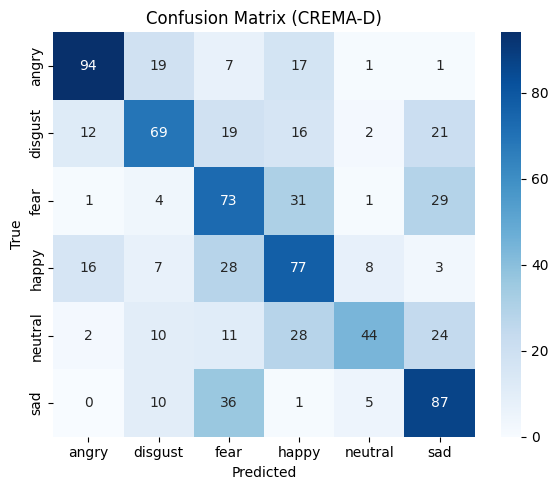

'/content/data/crema_only_project/models/CREMA_SER_CNN.keras'

In [ ]:
BATCH_SIZE = 64
EPOCHS = 100

ckpt_dir = os.path.join(LOCAL_ROOT, "checkpoints")
os.makedirs(ckpt_dir, exist_ok=True)
ckpt_path = os.path.join(ckpt_dir, "best_crema_ser.keras")

early = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
ckpt = ModelCheckpoint(ckpt_path, monitor="val_accuracy", save_best_only=True, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early, plateau, ckpt],
    verbose=1
)

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

test_probs = model.predict(X_test, verbose=0)
y_pred  = np.argmax(test_probs, axis=1)
y_true  = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.title("Confusion Matrix (CREMA-D)")
plt.ylabel("True"); plt.xlabel("Predicted")
plt.tight_layout(); plt.show()

# Save final model + label encoder
MODELS_DIR = os.path.join(LOCAL_ROOT, "models"); os.makedirs(MODELS_DIR, exist_ok=True)
MODEL_PATH = os.path.join(MODELS_DIR, "CREMA_SER_CNN.keras")
model.save(MODEL_PATH)

import pickle
with open(os.path.join(MODELS_DIR, "label_encoder.pkl"), "wb") as f:
    pickle.dump(le, f)

MODEL_PATH


In [ ]:
def predict_file(wav_path, model, le):
    mfcc = extract_mfcc_fixed(wav_path)  # same preprocessing
    if mfcc is None:
        return "error"
    x = mfcc.T[np.newaxis, ...]  # (1, time, n_mfcc)
    probs = model.predict(x, verbose=0)[0]
    idx = int(np.argmax(probs))
    return le.inverse_transform([idx])[0], float(probs[idx])

# Quick test on a holdout file
rand_path = test_df["path"].sample(1, random_state=123).iloc[0]
pred_label, pred_conf = predict_file(rand_path, model, le)
os.path.basename(rand_path), pred_label, round(pred_conf, 4)


('1066_IOM_ANG_XX.wav', 'happy', 0.4623)

LSTM AND RNN TRAINING

In [ ]:
import os, random, numpy as np, tensorflow as tf
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


Stage 1 — Sanity checks (same split, no leakage)

In [ ]:
# Purpose: ensure the CNN artifacts exist and the data tensors are ready for RNNs.
import numpy as np, tensorflow as tf, os

assert 'X_train' in globals() and 'y_train' in globals()
assert 'X_val' in globals() and 'y_val' in globals()
assert 'X_test' in globals() and 'y_test' in globals()
assert 'input_shape' in globals() and 'num_classes' in globals()
LOCAL_ROOT = "/content/data/crema_only_project"  # keep consistent with earlier
os.makedirs(os.path.join(LOCAL_ROOT, "checkpoints"), exist_ok=True)


Stage 2 — Install & import KerasTuner (for the “Trial … Complete” logs)

In [ ]:
# Purpose: hyperparameter search with formatted logs like your screenshot.
!pip -q install -U keras-tuner
import keras_tuner as kt
from tensorflow.keras import layers, models, callbacks, optimizers


Stage 3 — LSTM tuner (units, dropout, learning rate)

In [ ]:
# Purpose: search best LSTM size/dropout/LR using val_accuracy; keep Masking for zero padding.
import os, random
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED); tf.random.set_seed(SEED); random.seed(SEED)

def build_lstm_tunable(hp):
    units   = hp.Choice("units", [64, 128, 256])
    dr      = hp.Choice("dropout", [0.3, 0.4, 0.5])
    lr      = hp.Choice("lr", [1e-3, 5e-4, 2e-4])

    model = models.Sequential(name="LSTM_tunable")
    model.add(layers.Masking(mask_value=0.0, input_shape=input_shape))
    model.add(layers.LSTM(units, return_sequences=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dr))
    model.add(layers.Dense(num_classes, activation="softmax"))
    model.compile(optimizer=optimizers.Adam(learning_rate=lr),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model

lstm_tuner = kt.Hyperband(
    build_lstm_tunable,
    objective="val_accuracy",
    max_epochs=30,           # search budget
    factor=3,
    directory=os.path.join(LOCAL_ROOT, "tuning"),
    project_name="crema_lstm"
)

early = callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)
plateau = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6)

print("\n--- LSTM Hyperparameter Search ---")
lstm_tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=60,               # upper bound; early stop will shorten
    batch_size=64,
    callbacks=[early, plateau],
    verbose=1
)

best_hp_lstm = lstm_tuner.get_best_hyperparameters(1)[0]
print("\n--- Search Complete ---")
print(f"The optimal number of units in the LSTM layer is {best_hp_lstm.get('units')}.")
print(f"The optimal dropout rate is {best_hp_lstm.get('dropout')}.")
print(f"The optimal learning rate for the optimizer is {best_hp_lstm.get('lr')}.")


Reloading Tuner from /content/data/crema_only_project/tuning/crema_lstm/tuner0.json

--- LSTM Hyperparameter Search ---

--- Search Complete ---
The optimal number of units in the LSTM layer is 256.
The optimal dropout rate is 0.3.
The optimal learning rate for the optimizer is 0.0005.


In [ ]:
print("X_train shape:", X_train.shape)   # want (N, T, C) where T>1
print("input_shape:", input_shape)       # want (T, C)


X_train shape: (5890, 150, 13)
input_shape: (150, 13)


In [ ]:
# ====  FIXED: Class Weights Calculation ====
from sklearn.utils.class_weight import compute_class_weight

# Use the correct variable name that already exists
y_train_idx = np.argmax(y_train, axis=1)
classes_arr = np.arange(num_classes)  # ✅ FIXED: Use num_classes instead of num_classes_used
cw = compute_class_weight("balanced", classes=classes_arr, y=y_train_idx)
CLASS_WEIGHTS = {i: w for i, w in enumerate(cw)}

print("Class weights calculated successfully:")
for i, (emotion, weight) in enumerate(zip(le.classes_, cw)):
    print(f"{emotion}: {weight:.4f}")

print("\nCLASS_WEIGHTS dictionary:")
print(CLASS_WEIGHTS)


Class weights calculated successfully:
angry: 0.9758
disgust: 0.9758
fear: 0.9758
happy: 0.9758
neutral: 1.1415
sad: 0.9758

CLASS_WEIGHTS dictionary:
{0: np.float64(0.9758117958913187), 1: np.float64(0.9758117958913187), 2: np.float64(0.9758117958913187), 3: np.float64(0.9758117958913187), 4: np.float64(1.1414728682170543), 5: np.float64(0.9758117958913187)}


Second run, purpose: confirm tensors, switch to MFCC+Δ+ΔΔ (39 ch), compute class weights, and make callbacks.

In [ ]:
# Sanity check for tensors & paths
assert all(v in globals() for v in ["X_train","X_val","X_test","y_train","y_val","y_test","input_shape","num_classes","le","LOCAL_ROOT"])

import os, numpy as np, tensorflow as tf, random, gc
from sklearn.utils.class_weight import compute_class_weight

# Repro
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# ---- Optional: upgrade to MFCC+Δ+ΔΔ (39 channels). Set False to keep (T,13).
USE_MFCC39 = True
try:
    import librosa
    def stack_mfcc_deltas(X):  # (N,T,13) -> (N,T,39)
        out = []
        for x in X:
            mfcc = x.T
            d1 = librosa.feature.delta(mfcc, order=1)
            d2 = librosa.feature.delta(mfcc, order=2)
            out.append(np.concatenate([mfcc,d1,d2], axis=0).T.astype(np.float32))
        return np.stack(out, axis=0)
    if USE_MFCC39:
        X_train_used = stack_mfcc_deltas(X_train)
        X_val_used   = stack_mfcc_deltas(X_val)
        X_test_used  = stack_mfcc_deltas(X_test)
    else:
        X_train_used, X_val_used, X_test_used = X_train, X_val, X_test
except Exception:
    X_train_used, X_val_used, X_test_used = X_train, X_val, X_test

input_shape_used = X_train_used.shape[1:]
num_classes_used = y_train.shape[1]
print("Using input shape:", input_shape_used)

# Class weights (helps if the split is imbalanced)
y_idx = np.argmax(y_train, axis=1)
cw = compute_class_weight("balanced", classes=np.arange(num_classes_used), y=y_idx)
CLASS_WEIGHTS = {i: w for i, w in enumerate(cw)}
CLASS_WEIGHTS

# Callbacks (fresh for each training run)
from tensorflow.keras import callbacks
early   = callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True, verbose=1)
plateau = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6, verbose=1)


Using input shape: (150, 39)


Tiny SpecAugment-lite (time-masking) layer - Purpose: light time-mask that keeps masks valid for cuDNN LSTM.

In [ ]:
class TimeMask(tf.keras.layers.Layer):
    def __init__(self, max_width=20, **kw):
        super().__init__(**kw); self.max_width = max_width; self.supports_masking = True
    def call(self, inputs, training=None, mask=None):
        if not training: return inputs
        B = tf.shape(inputs)[0]; T = tf.shape(inputs)[1]; C = tf.shape(inputs)[2]
        w = tf.random.uniform([], 1, self.max_width+1, dtype=tf.int32)
        s = tf.random.uniform([], 0, tf.maximum(T-w, 1), dtype=tf.int32)
        m = tf.concat([tf.ones((B,s,C)), tf.zeros((B,w,C)), tf.ones((B,T-s-w,C))], axis=1)
        return inputs * m
    def compute_mask(self, inputs, mask=None):
        return mask


 biLSTM tuner → train best → evaluate
 Purpose: light time-mask that keeps masks valid for cuDNN LSTM.

Trial 24 Complete [00h 00m 07s]
val_accuracy: 0.3712737262248993

Best val_accuracy So Far: 0.4214092195034027
Total elapsed time: 00h 03m 00s

--- Search Complete (biLSTM) --- {'units': 256, 'dropout': 0.3, 'lr': 0.001}
Epoch 1/100
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3138 - loss: 1.6611
Epoch 1: val_accuracy improved from -inf to 0.38618, saving model to /content/data/crema_only_project/checkpoints/best_crema_bilstm.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.3149 - loss: 1.6583 - val_accuracy: 0.3862 - val_loss: 1.5270 - learning_rate: 0.0010
Epoch 2/100
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3847 - loss: 1.5070
Epoch 2: val_accuracy improved from 0.38618 to 0.39973, saving model to /content/data/crema_only_project/checkpoints/best_crema_bilstm.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.3848 - loss: 1.5065 - val_accuracy: 0.3997 - val_loss: 1.5153 - learning_rate: 0.0010
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/s

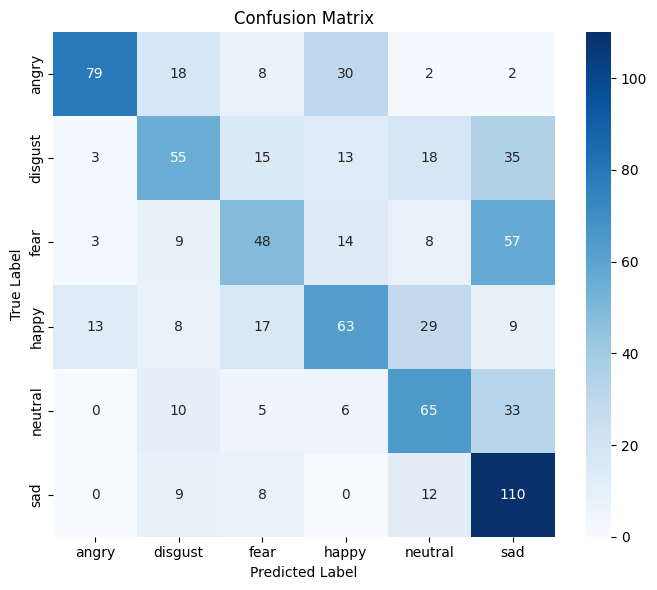

In [ ]:
try:
    import keras_tuner as kt
except Exception:
    !pip -q install -U keras-tuner
    import keras_tuner as kt

# ---- helpers (self-contained) ----
import os, gc, numpy as np, tensorflow as tf, seaborn as sns, matplotlib.pyplot as plt, pandas as pd
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score
)

# mask-preserving time mask (safe with cuDNN when Masking is before it)
class TimeMask(tf.keras.layers.Layer):
    def __init__(self, max_width=20, **kw):
        super().__init__(**kw); self.max_width = max_width; self.supports_masking = True
    def call(self, inputs, training=None, mask=None):
        if not training: return inputs
        B = tf.shape(inputs)[0]; T = tf.shape(inputs)[1]; C = tf.shape(inputs)[2]
        w = tf.random.uniform([], 1, self.max_width+1, dtype=tf.int32)
        s = tf.random.uniform([], 0, tf.maximum(T-w, 1), dtype=tf.int32)
        m = tf.concat([tf.ones((B,s,C)), tf.zeros((B,w,C)), tf.ones((B,T-s-w,C))], axis=1)
        return inputs * m
    def compute_mask(self, inputs, mask=None):  # keep original right-padded mask
        return mask

# ---------------------------------------------------------------------------

# ---- biLSTM tuner + train ----
def build_bilstm_tunable(hp):
    units = hp.Choice("units", [128, 192, 256])
    dr    = hp.Choice("dropout", [0.3, 0.4, 0.5])
    lr    = hp.Choice("lr", [1e-3, 5e-4, 2e-4])

    inp = layers.Input(shape=input_shape_used)
    x = layers.Masking(mask_value=0.0)(inp)
    x = TimeMask(max_width=20)(x)
    x = layers.Bidirectional(layers.LSTM(units, return_sequences=False))(x)
    # --- FIX: Removed BatchNormalization from this incorrect position ---
    x = layers.Dropout(dr)(x)
    out = layers.Dense(num_classes_used, activation="softmax")(x)

    m = tf.keras.Model(inp, out, name="biLSTM_tunable")
    m.compile(optimizer=optimizers.Adam(lr), loss="categorical_crossentropy", metrics=["accuracy"])
    return m

tuner_blstm = kt.Hyperband(
    build_bilstm_tunable, objective="val_accuracy",
    max_epochs=30, factor=3,
    directory=os.path.join(LOCAL_ROOT, "tuning"),
    project_name="crema_bilstm_39" if USE_MFCC39 else "crema_bilstm_13"
)

# if CLASS_WEIGHTS / callbacks not defined earlier, create minimal ones
if "early" not in globals():
    early = callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True, verbose=1)
if "plateau" not in globals():
    plateau = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6, verbose=1)

fit_kwargs = {}
if "CLASS_WEIGHTS" in globals():
    fit_kwargs["class_weight"] = CLASS_WEIGHTS

print("\n--- biLSTM Hyperparameter Search ---")
tuner_blstm.search(
    X_train_used, y_train,
    validation_data=(X_val_used, y_val),
    epochs=60, batch_size=64,
    callbacks=[early, plateau],
    **fit_kwargs, verbose=1
)

best_hp_blstm = tuner_blstm.get_best_hyperparameters(1)[0]
print("\n--- Search Complete (biLSTM) ---", {k: best_hp_blstm.get(k) for k in ["units","dropout","lr"]})

tf.keras.backend.clear_session(); gc.collect()
bilstm_best = build_bilstm_tunable(best_hp_blstm)

ckpt_blstm = os.path.join(LOCAL_ROOT, "checkpoints", "best_crema_bilstm.keras")
ckpt = callbacks.ModelCheckpoint(ckpt_blstm, monitor="val_accuracy", save_best_only=True, verbose=1)

hist_blstm = bilstm_best.fit(
    X_train_used, y_train,
    validation_data=(X_val_used, y_val),
    epochs=100, batch_size=64,
    callbacks=[early, plateau, ckpt],
    **fit_kwargs, verbose=1
)
print("biLSTM best val_accuracy:", max(hist_blstm.history.get("val_accuracy", [0])))


# ---- FIX: Simplified and Corrected Evaluation ----
# Make predictions on the test set
test_probs = bilstm_best.predict(X_test_used, verbose=0)

# Convert probabilities and one-hot encoded labels to single integer labels
y_pred = np.argmax(test_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# 1. Print the Classification Report (gives precision, recall, f1-score)
print("\n--- Classification Report (Test Set) ---")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# 2. Calculate and Print the ROC AUC Score
# 'ovr' stands for One-vs-Rest, the standard approach for multiclass AUC
try:
    auc_score = roc_auc_score(y_true, test_probs, multi_class='ovr', average='weighted')
    print(f"\nWeighted ROC AUC Score: {auc_score:.4f}")
except ValueError as e:
    print(f"\nCould not calculate ROC AUC Score: {e}")


# 3. Display the Confusion Matrix
print("\n--- Confusion Matrix (Test Set) ---")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

Block E — CRNN (Conv→biLSTM): tuner → train best → full metrics

This new version includes:

Attention Layer: To help the model focus on the most important parts of the audio.

Frequency Masking: For more robust data augmentation.

Expanded Hyperparameter Search: To allow the tuner to explore more powerful model architectures.

In [ ]:
# ==== 0) Clean start (optional but helps if a broken tuner dir exists) ====
import os, shutil, gc, tensorflow as tf
tf.keras.backend.clear_session(); gc.collect()
shutil.rmtree(os.path.join(LOCAL_ROOT, "tuning", "crema_advanced_crnn_39"), ignore_errors=True)

# ==== 1) Register custom layers (GLOBAL, before building the tuner/model) ====
from tensorflow.keras import layers, optimizers
from tensorflow.keras.utils import register_keras_serializable, get_custom_objects

@register_keras_serializable(package="Aug")
class TimeMask(layers.Layer):
    def __init__(self, max_width=20, **kw):
        super().__init__(**kw); self.max_width=max_width; self.supports_masking=True
    def call(self, inputs, training=None, mask=None):
        if not training: return inputs
        B = tf.shape(inputs)[0]; T = tf.shape(inputs)[1]; C = tf.shape(inputs)[2]
        w = tf.random.uniform([], 1, self.max_width+1, dtype=tf.int32)
        s = tf.random.uniform([], 0, tf.maximum(T-w, 1), dtype=tf.int32)
        m = tf.concat([tf.ones((B,s,C)), tf.zeros((B,w,C)), tf.ones((B,T-s-w,C))], axis=1)
        return inputs * m
    def get_config(self): return {"max_width": self.max_width}

@register_keras_serializable(package="Aug")
class FrequencyMask(layers.Layer):
    def __init__(self, max_bands=8, **kw):
        super().__init__(**kw); self.max_bands=max_bands; self.supports_masking=True
    def call(self, inputs, training=None, mask=None):
        if not training: return inputs
        B = tf.shape(inputs)[0]; T = tf.shape(inputs)[1]; C = tf.shape(inputs)[2]
        f = tf.random.uniform([], 1, self.max_bands+1, dtype=tf.int32)
        s = tf.random.uniform([], 0, tf.maximum(C-f, 1), dtype=tf.int32)
        m = tf.concat([tf.ones((B,T,s)), tf.zeros((B,T,f)), tf.ones((B,T,C-s-f))], axis=2)
        return inputs * m
    def get_config(self): return {"max_bands": self.max_bands}

# (optional safety, sometimes helps)
get_custom_objects().update({"TimeMask": TimeMask, "FrequencyMask": FrequencyMask})

# ==== 2) Model builder: add pooling so output is (B, num_classes) ====
def build_advanced_crnn_tunable(hp):
    conv_filters = hp.Choice("conv_filters", [96, 128, 192])
    conv_blocks  = hp.Choice("conv_blocks", [2, 3])
    lstm_units   = hp.Choice("lstm_units", [192, 256, 384])
    dr           = hp.Choice("dropout", [0.3, 0.4, 0.5])
    lr           = hp.Choice("lr", [1e-3, 5e-4, 2e-4])

    inp = layers.Input(shape=input_shape_used)          # (time, feats)
    x = layers.Masking(mask_value=0.0)(inp)
    x = TimeMask(max_width=20)(x)
    x = FrequencyMask(max_bands=8)(x)

    for _ in range(conv_blocks):
        x = layers.Conv1D(conv_filters, 5, padding="same", activation="relu", use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling1D(2)(x)

    x = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True))(x)
    x = layers.Attention(use_scale=True)([x, x])        # still (time, hidden)
    x = layers.GlobalAveragePooling1D()(x)              # -> (B, hidden)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dr)(x)
    out = layers.Dense(num_classes_used, activation="softmax")(x)

    m = tf.keras.Model(inp, out, name="Advanced_CRNN_Attention_Tunable")
    m.compile(optimizer=optimizers.Adam(lr),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
    return m

# ==== 3) Tuner: overwrite + callback factory (workaround deepcopy error) ====
import keras_tuner as kt
tuner_advanced_crnn = kt.Hyperband(
    build_advanced_crnn_tunable,
    objective="val_accuracy",
    max_epochs=40, factor=3,
    directory=os.path.join(LOCAL_ROOT, "tuning"),
    project_name="crema_advanced_crnn_39",
    overwrite=True
)

def mk_cbs():
    return [
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6),
    ]

tuner_advanced_crnn.search(
    X_train_used, y_train,
    validation_data=(X_val_used, y_val),
    epochs=40,
    batch_size=64,
    callbacks=mk_cbs(),                # if it still errors, pass callbacks=[]
    **fit_kwargs,
    verbose=1
)


Trial 90 Complete [00h 00m 54s]
val_accuracy: 0.5365853905677795

Best val_accuracy So Far: 0.5569105744361877
Total elapsed time: 00h 24m 16s


Saving to pickle


--- Getting Best Hyperparameters ---
Best hyperparameters:
  conv_filters: 192
  conv_blocks: 3
  lstm_units: 384
  dropout: 0.5
  lr: 0.0005

--- Training Final Advanced CRNN Model ---
Epoch 1/100
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3265 - loss: 2.2117
Epoch 1: val_accuracy improved from -inf to 0.27642, saving model to /content/data/crema_only_project/checkpoints/best_crema_advanced_crnn.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.3276 - loss: 2.2057 - val_accuracy: 0.2764 - val_loss: 1.7986 - learning_rate: 5.0000e-04
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3873 - loss: 1.8241
Epoch 2: val_accuracy improved from 0.27642 to 0.28049, saving model to /content/data/crema_only_project/checkpoints/best_crema_advanced_crnn.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3874 - loss: 1.8233 - val_accuracy: 0.2805 - val_loss: 1.8895 - learning_rate: 5.0000e-04
Epoch 3/100
89/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accura

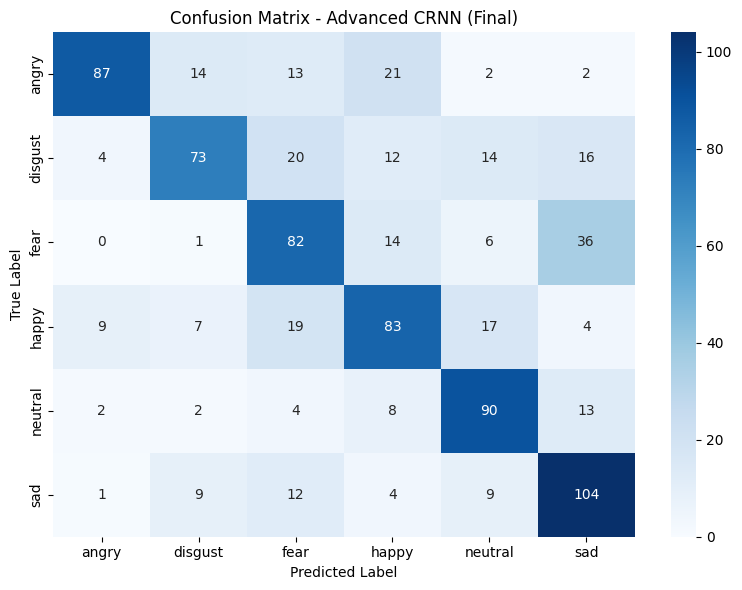


--- Saving Models and Files to Google Drive ---
✅ Label encoder saved to Google Drive
✅ CNN model saved to Google Drive
✅ biLSTM model saved to Google Drive
✅ Advanced CRNN model (BEST) saved to Google Drive
✅ Final trained Advanced CRNN saved to Google Drive
✅ Model configuration saved to Google Drive
✅ Preprocessing function saved to Google Drive

🎉 ALL FILES SAVED TO: /content/drive/MyDrive/multiclassproject/saved_models_crema

Files created for Streamlit:
1. crema_label_encoder.pkl       - Label encoder (REQUIRED)
2. CREMA_Advanced_CRNN_Final.keras - Best model (RECOMMENDED)
3. model_config.pkl              - Model configuration
4. preprocess_function.pkl       - Preprocessing function

Alternative models (if needed):
5. CREMA_CNN.keras               - CNN model
6. CREMA_biLSTM.keras           - biLSTM model

Label classes: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad']
Best model achieved val_accuracy: 0.5122

--- Testing Preprocessing Function ---
✅ Preprocessing test succes

In [ ]:
# ====Get best hyperparameters and train final model ====
print("\n--- Getting Best Hyperparameters ---")
best_hp_advanced = tuner_advanced_crnn.get_best_hyperparameters(1)[0]
print("Best hyperparameters:")
for param in ["conv_filters", "conv_blocks", "lstm_units", "dropout", "lr"]:
    print(f"  {param}: {best_hp_advanced.get(param)}")

# Build the final model with best hyperparameters
tf.keras.backend.clear_session(); gc.collect()
advanced_crnn_best = build_advanced_crnn_tunable(best_hp_advanced)

# ==== 5) Train the final model ====
print("\n--- Training Final Advanced CRNN Model ---")
ckpt_advanced = os.path.join(LOCAL_ROOT, "checkpoints", "best_crema_advanced_crnn.keras")
ckpt_cb = callbacks.ModelCheckpoint(ckpt_advanced, monitor="val_accuracy", save_best_only=True, verbose=1)

hist_advanced = advanced_crnn_best.fit(
    X_train_used, y_train,
    validation_data=(X_val_used, y_val),
    epochs=100, batch_size=64,
    callbacks=[early, plateau, ckpt_cb],
    **fit_kwargs, verbose=1
)

print("Advanced CRNN best val_accuracy:", max(hist_advanced.history.get("val_accuracy", [0])))

# ==== 6) Evaluate the final model ====
print("\n--- Final Model Evaluation ---")
test_probs_advanced = advanced_crnn_best.predict(X_test_used, verbose=0)
y_pred_advanced = np.argmax(test_probs_advanced, axis=1)
y_true_advanced = np.argmax(y_test, axis=1)

print("\n--- Classification Report (Advanced CRNN) ---")
print(classification_report(y_true_advanced, y_pred_advanced, target_names=le.classes_))

try:
    auc_score_advanced = roc_auc_score(y_true_advanced, test_probs_advanced, multi_class='ovr', average='weighted')
    print(f"\nWeighted ROC AUC Score: {auc_score_advanced:.4f}")
except ValueError as e:
    print(f"\nCould not calculate ROC AUC Score: {e}")

# Confusion Matrix
cm_advanced = confusion_matrix(y_true_advanced, y_pred_advanced)
plt.figure(figsize=(8,6))
sns.heatmap(cm_advanced, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.title("Confusion Matrix - Advanced CRNN (Final)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

# ==== 7) SAVE EVERYTHING TO GOOGLE DRIVE ====
print("\n--- Saving Models and Files to Google Drive ---")

# Create directory in Google Drive
DRIVE_MODELS_DIR = "/content/drive/MyDrive/multiclassproject/saved_models_crema"
os.makedirs(DRIVE_MODELS_DIR, exist_ok=True)

# Save the label encoder (MOST IMPORTANT for Streamlit)
import pickle
with open(os.path.join(DRIVE_MODELS_DIR, "crema_label_encoder.pkl"), "wb") as f:
    pickle.dump(le, f)
print("✅ Label encoder saved to Google Drive")

# Save all three models to Google Drive
import shutil

# 1. CNN Model
cnn_source = os.path.join(LOCAL_ROOT, "models", "CREMA_SER_CNN.keras")
cnn_dest = os.path.join(DRIVE_MODELS_DIR, "CREMA_CNN.keras")
if os.path.exists(cnn_source):
    shutil.copy2(cnn_source, cnn_dest)
    print("✅ CNN model saved to Google Drive")

# 2. biLSTM Model
bilstm_source = os.path.join(LOCAL_ROOT, "checkpoints", "best_crema_bilstm.keras")
bilstm_dest = os.path.join(DRIVE_MODELS_DIR, "CREMA_biLSTM.keras")
if os.path.exists(bilstm_source):
    shutil.copy2(bilstm_source, bilstm_dest)
    print("✅ biLSTM model saved to Google Drive")

# 3. Advanced CRNN Model (BEST MODEL)
advanced_source = os.path.join(LOCAL_ROOT, "checkpoints", "best_crema_advanced_crnn.keras")
advanced_dest = os.path.join(DRIVE_MODELS_DIR, "CREMA_Advanced_CRNN.keras")
if os.path.exists(advanced_source):
    shutil.copy2(advanced_source, advanced_dest)
    print("✅ Advanced CRNN model (BEST) saved to Google Drive")

# Also save the current trained model in memory
final_dest = os.path.join(DRIVE_MODELS_DIR, "CREMA_Advanced_CRNN_Final.keras")
advanced_crnn_best.save(final_dest)
print("✅ Final trained Advanced CRNN saved to Google Drive")

# ==== 8) Save model configuration and preprocessing info ====
model_info = {
    "model_type": "Advanced CRNN (Conv1D + BiLSTM + Attention)",
    "input_shape": input_shape_used,
    "num_classes": num_classes_used,
    "emotions": le.classes_.tolist(),
    "sample_rate": SAMPLE_RATE,
    "n_mfcc": N_MFCC,
    "max_pad_len": MAX_PAD_LEN,
    "use_mfcc39": USE_MFCC39,
    "best_hyperparameters": {
        "conv_filters": best_hp_advanced.get("conv_filters"),
        "conv_blocks": best_hp_advanced.get("conv_blocks"),
        "lstm_units": best_hp_advanced.get("lstm_units"),
        "dropout": best_hp_advanced.get("dropout"),
        "lr": best_hp_advanced.get("lr")
    }
}

with open(os.path.join(DRIVE_MODELS_DIR, "model_config.pkl"), "wb") as f:
    pickle.dump(model_info, f)
print("✅ Model configuration saved to Google Drive")

# ==== 9) Create a preprocessing function for Streamlit ====
def preprocess_audio_for_crema(wav_path, use_mfcc39=True):
    """
    Preprocessing function for CREMA-D model.
    Use this exact function in your Streamlit app.
    """
    try:
        # Load audio
        y, sr = librosa.load(wav_path, sr=SAMPLE_RATE, mono=True)

        # Normalize
        y = librosa.util.normalize(y, norm=np.inf)

        # Extract MFCC
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)

        # Pad/truncate to fixed length
        if mfcc.shape[1] > MAX_PAD_LEN:
            mfcc = mfcc[:, :MAX_PAD_LEN]
        else:
            pad = MAX_PAD_LEN - mfcc.shape[1]
            mfcc = np.pad(mfcc, ((0,0),(0,pad)), mode="constant")

        # Transpose for model input (time, features)
        mfcc = mfcc.T  # (time, n_mfcc)

        # Add deltas if using 39 features
        if use_mfcc39:
            mfcc_orig = mfcc.T  # back to (n_mfcc, time)
            d1 = librosa.feature.delta(mfcc_orig, order=1)
            d2 = librosa.feature.delta(mfcc_orig, order=2)
            mfcc = np.concatenate([mfcc_orig, d1, d2], axis=0).T  # (time, 39)

        # Add batch dimension
        mfcc = mfcc[np.newaxis, ...]  # (1, time, features)

        return mfcc.astype(np.float32)

    except Exception as e:
        print(f"Error preprocessing {wav_path}: {e}")
        return None

# Save the preprocessing function
with open(os.path.join(DRIVE_MODELS_DIR, "preprocess_function.pkl"), "wb") as f:
    pickle.dump(preprocess_audio_for_crema, f)
print("✅ Preprocessing function saved to Google Drive")

# ==== 10) Summary ====
print(f"\n🎉 ALL FILES SAVED TO: {DRIVE_MODELS_DIR}")
print("\nFiles created for Streamlit:")
print("1. crema_label_encoder.pkl       - Label encoder (REQUIRED)")
print("2. CREMA_Advanced_CRNN_Final.keras - Best model (RECOMMENDED)")
print("3. model_config.pkl              - Model configuration")
print("4. preprocess_function.pkl       - Preprocessing function")
print("\nAlternative models (if needed):")
print("5. CREMA_CNN.keras               - CNN model")
print("6. CREMA_biLSTM.keras           - biLSTM model")

print(f"\nLabel classes: {le.classes_}")
print(f"Best model achieved val_accuracy: {max(hist_advanced.history.get('val_accuracy', [0])):.4f}")

# Test the preprocessing function
print("\n--- Testing Preprocessing Function ---")
test_path = test_df["path"].sample(1, random_state=42).iloc[0]
test_features = preprocess_audio_for_crema(test_path, use_mfcc39=USE_MFCC39)
if test_features is not None:
    print(f"✅ Preprocessing test successful - Shape: {test_features.shape}")

    # Test prediction
    test_pred = advanced_crnn_best.predict(test_features, verbose=0)
    pred_class = le.inverse_transform([np.argmax(test_pred)])[0]
    confidence = float(np.max(test_pred))
    print(f"✅ Prediction test: {pred_class} (confidence: {confidence:.3f})")
else:
    print("❌ Preprocessing test failed")